In [1]:
import os
import nltk
import pandas as pd
import csv
import math
import re

## Preprocessing 
#### Tokenizing;  Tagging;  Segmentation;  Establishing annotation-corpus 

In [13]:
filelist = [filename for filename in os.listdir("./Dataset") if filename.endswith("txt")]
print(filelist)

['2009-01-20-Barack-Obama.txt', '1993-01-20-William-J-Clinton.txt', '2017-01-20-Donald-J-Trump.txt', '2001-01-20-George-W-Bush.txt']


In [14]:
from nltk.tag.stanford import StanfordPOSTagger
# enter the paths of Stanford POS Tagger .jar file as well as the model to be used
jar = "/Users/Shared/stanford-postagger-full-2018-10-16/stanford-postagger-3.9.2.jar"
model = "/Users/Shared/stanford-postagger-full-2018-10-16/models/english-left3words-distsim.tagger"
# Instantiate an English pos-tagger using the jar and model defined above 
pos_tagger_en = StanfordPOSTagger(model, jar, encoding = "utf-8")

In [15]:
# Use Stanford POS-tagger defined above to Tag all source texts (English)

for fileid in filelist:
    print(fileid)            
    with open ("Dataset/" + fileid, encoding = "utf-8") as f:   
        raw = f.read()
        tokenized_text = nltk.word_tokenize(raw)              # tokenizing
        tagged_text = pos_tagger_en.tag(tokenized_text)      # pos-tagging

# Write the tagged text into new .txt files in specific format respectively

        with open ("Dataset/Tagged/" + fileid, "w", encoding = "utf-8") as tag_f:
            write_text = ""
            for (a, b) in tagged_text:
                write_text += a + "_" + b +" "   # Combine word and tag together in the format: "My_PRP$ "
            
            # Add newline character after the character which marks the end of a sentence 
            # "_." includes "!", "?" these sentence closers and "_:" includes ";", ":", "--" 
            
            result = write_text.replace("_. ", "_.\n").replace("_:", "_:\n")
    
            tag_f.write(result)       # Write all the results into corresponding .txt file.
        

2009-01-20-Barack-Obama.txt
1993-01-20-William-J-Clinton.txt
2017-01-20-Donald-J-Trump.txt
2001-01-20-George-W-Bush.txt


In [16]:
for fileid in filelist:
    with open ("Dataset/Tagged/"+ fileid) as f:
        sentences = [row for row in f]
        # Get corresponding .csv files which contains sentence pairs of the speech in the first and second column.
        df_sent = pd.DataFrame({"sent_pair_1" : sentences[:-1], "sent_pair_2" : sentences[1:]})
        df_sent.to_csv("Dataset/Tagged/"+ fileid[:-4] + "_sent_pair.csv", sep = ",", encoding = "utf-8", index = False)

## Feature Engineering 

In [2]:
# Feature for special types of parallelism: Anaphora / Epistrophe / Anadiplosis
# Check whether repetition of bigrams occurs in sentence-initial/-final position

def specialParaLexical(sent1, sent2):
    numRepetitionBi = 0
    s1 = sent1.split()
    s2 = sent2.split()
    if len(s1) < 4 or len(s2) < 4:
        return 0
    # For Epistrophe and Anadiplosis
    for bi in nltk.bigrams([w.lower() for w in s1[-4:]]):
        if bi in nltk.bigrams([w.lower() for w in s2[-4:]]) or bi in nltk.bigrams([w.lower() for w in s2[:4]]):
            numRepetitionBi += 1
    # For Anaphora
    if numRepetitionBi == 0:
        while len(s1) > 3:             # The sentence-initial/-final part should consist of at least 4 words
            bi_initialS1 = nltk.bigrams([w.lower() for w in s1[:4]])
            bi_initialS2 = nltk.bigrams([w.lower() for w in s2[:4]])
            for bi in bi_initialS1:
                if bi in bi_initialS2:
                    numRepetitionBi += 1
            if ",_," not in s1 or numRepetitionBi > 0:
                break
            # Tackle the situation when sent1 is partially parallel with sent2
            elif ",_," in s1: 
                # Chop off the unparallel sub-sentence and 
                # continue searching parallel structure in the rest of the sentence
                s1 = s1[s1.index(",_,")+1 :] 
        while len(s2) > 3:
            bi_initialS1 = nltk.bigrams([w.lower() for w in s1[:4]])
            bi_initialS2 = nltk.bigrams([w.lower() for w in s2[:4]])
            for bi in bi_initialS2:
                if bi in bi_initialS1:
                    numRepetitionBi += 1
            if ",_," not in s2 or numRepetitionBi > 0:
                break
            # Tackle the situation when sent2 is partially parallel with sent1
            elif ",_," in s2: 
                # Chop off the unparallel sub-sentence and 
                # continue searching parallel structure in the rest of the sentence
                    s2 = s2[s2.index(",_,")+1 :] 
    
    return numRepetitionBi

In [3]:
specialParaLexical("We_PRP are_VBP not_RB this_DT story_NN 's_POS author_NN ,_, who_WP fills_VBZ time_NN and_CC eternity_NN with_IN his_PRP$ purpose_NN ._.","Yet_CC ,_, his_PRP$ purpose_NN is_VBZ achieved_VBN in_IN our_PRP$ duty_NN ._.")

1

In [4]:
# Test some sentence pairs
s1 = "We_PRP rededicate_VB ourselves_PRP to_TO the_DT very_RB idea_NN of_IN America_NNP ,_, an_DT idea_NN born_VBN in_IN revolution_NN and_CC renewed_VBN through_IN two_CD centuries_NNS of_IN challenge_NN ;_:"
s2 = "an_DT idea_NN tempered_VBN by_IN the_DT knowledge_NN that_IN ,_, but_CC for_IN fate_NN ,_, we_PRP ,_, the_DT fortunate_JJ ,_, and_CC the_DT unfortunate_JJ might_MD have_VB been_VBN each_DT other_JJ ;_:"
s3 = " an_DT idea_NN ennobled_VBN by_IN the_DT faith_NN that_WDT our_PRP$ Nation_NNP can_MD summon_VB from_IN its_PRP$ myriad_JJ diversity_NN the_DT deepest_JJS measure_NN of_IN unity_NN ;_:"

s4 = "We_PRP will_MD make_VB America_NNP safe_JJ again_RB ._."
s5 = "And_CC ,_, yes_UH ,_, together_RB ,_, we_PRP will_MD make_VB America_NNP great_JJ again_RB ._."

In [5]:
s6 = "We_PRP remain_VBP a_DT young_JJ nation_NN ,_, but_CC in_IN the_DT words_NNS of_IN Scripture_NNP ,_, the_DT time_NN has_VBZ come_VBN to_TO set_VB aside_RB childish_JJ things_NNS ._."
s7 = "The_DT time_NN has_VBZ come_VBN to_TO reaffirm_VB our_PRP$ enduring_VBG spirit_NN ,_, to_TO choose_VB our_PRP$ better_JJR history_NN ,_, to_TO carry_VB forward_RP that_DT precious_JJ gift_NN ,_, that_WDT noble_JJ idea_NN passed_VBN on_IN from_IN generation_NN to_TO generation_NN :_:"

In [6]:
print(specialParaLexical(s1, s2))
print(specialParaLexical(s1, s3))
print(specialParaLexical(s1, s4))

2
2
0


### Parameter Selection for Semantic (Emotional) Features 

In [7]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
nlp = spacy.load("en_core_web_md")

#### Process the VAD lexicon 

In [8]:
info = []
with open ("/Users/genecosmo/Desktop/Projekt_CL/Senti_Lexi/NRC-VAD-Lexicon.txt", encoding = "utf-8") as f:
    raw = f.readlines()
    info = [row.split() for row in raw[1:]]
    # There are some entries which contains phrases or describing words for the word. 
        #['business', 'man', '0.530', '0.598', '0.933']
        #['extremely', 'negative', '0.030', '0.786', '0.311']
        #['extremely', 'positive', '0.993', '0.730', '0.839'] 
    # These kind of entries can be problematic for processing and thus are deleted in this project.
    cleanedInfo = [row for row in info if len(row)== 4]
    print("Altogether ", len(cleanedInfo), "entries can be used in this project.")

Altogether  19874 entries can be used in this project.


In [9]:
(len(info) - 19874 )/20007

0.006647673314339981

In [10]:
# Store the data in a managable way.
entries = [item[0] for item in cleanedInfo]
valence = [item[1] for item in cleanedInfo]
arousal = [item[2] for item in cleanedInfo]
dominance = [item[3] for item in cleanedInfo]
dict_W_V = dict(zip(entries, valence))
dict_W_A = dict(zip(entries, arousal))
dict_W_D = dict(zip(entries, dominance))
print(dict_W_D["renewal"])

0.672


In [11]:
# Basic information of the dataset
rows = []
with open ("/Users/genecosmo/Desktop/Projekt_CL/Dataset/Dataset_JW_0103.csv", encoding = "utf-8") as f:
    raw = csv.reader(f, delimiter = ",")
    rows = [row for row in raw]
    print(rows[:3])
print()
dataset = rows[1:]
sentsP1 = [item[0] for item in dataset]
tags = [item[2] for item in dataset]
print("Altogether ", len(tags), "pairs of sentences.")
print(tags.count("T"), "pairs are tagged as T.")
print(tags.count("F"), "pairs are tagged as F.")

[['sent_pair_1', 'sent_pair_2', 'tag'], ['Chief_NNP Justice_NNP Roberts_NNP ,_, President_NNP Carter_NNP ,_, President_NNP Clinton_NNP ,_, President_NNP Bush_NNP ,_, President_NNP Obama_NNP ,_, fellow_JJ Americans_NNPS ,_, and_CC people_NNS of_IN the_DT world_NN :_:\n', ' Thank_VB you_PRP ._.\n', 'F'], [' Thank_VB you_PRP ._.\n', 'We_PRP ,_, the_DT citizens_NNS of_IN America_NNP ,_, are_VBP now_RB joined_VBN in_IN a_DT great_JJ national_JJ effort_NN to_TO rebuild_VB our_PRP$ country_NN and_CC restore_VB its_PRP$ promise_NN for_IN all_DT of_IN our_PRP$ people_NNS ._.\n', 'F']]

Altogether  448 pairs of sentences.
100 pairs are tagged as T.
348 pairs are tagged as F.


In [12]:
# Method for getting list of lemmas of all words in a sentence 
def lemmatize(sent):
    sent = " ".join([w[:w.index("_")] for w in sent.split()])
    doc = nlp(sent)       
    lemmas = [token.lemma_.lower() for token in doc if not token.is_punct]
    return lemmas

In [13]:
lemmatize( 'The_DT enemy_NN was_VBD advancing_VBG ._.')

['the', 'enemy', 'be', 'advance']

In [14]:
def getAvgArousal(sent):
    sumScore=0
    lemmas = lemmatize(sent)
    for lemma in lemmas:
        for key in dict_W_A.keys():
            if lemma==key:
                sumScore += float(dict_W_A[key])
    if len(lemmas) == 0:
        return 0
    else:
        avg = round(sumScore/len(lemmas), 4)
        return avg

In [15]:
print(getAvgArousal("The_DT enemy_NN was_VBD advancing_VBG ._."))
print(getAvgArousal("The_DT Capital_NN was_VBD abandoned_VBN ._."))

0.3765
0.3147


In [16]:
def getAvgDominance(sent):
    sumScore=0
    lemmas = lemmatize(sent)
    for lemma in lemmas:
        for key in dict_W_D.keys():
            if lemma==key:
                sumScore += float(dict_W_D[key])
    if len(lemmas) == 0:
        return 0
    else:
        avg = round(sumScore/len(lemmas), 4)
        return avg

In [17]:
def getAvgV(sent):
    sumScore=0
    lemmas = lemmatize(sent)
    for lemma in lemmas:
        for key in dict_W_V.keys():
            if lemma==key:
                sumScore += float(dict_W_V[key])
    if len(lemmas) == 0:
        return 0
    else:
        avg = round(sumScore/len(lemmas), 4)
        return avg

In [18]:
# Get the average Arousal & Dominance scores for all sentences
# and store them in corresponding lists.
intensity_V = []
intensity_A = []
intensity_D = []
for sent in sentsP1:
    intensity_V.append(getAvgV(sent))
    
for sent in sentsP1:
    intensity_A.append(getAvgArousal(sent))
    
for sent in sentsP1:
    intensity_D.append(getAvgDominance(sent))

In [89]:
# Plot the scores of the corresponding emotional dimension 
# for a specified number of sentences 

def plotScores(emoDimension, num):
    axis_x = [i for i in range(num, num+100)]
    print(len(axis_x))
    axis_y1 = intensity_A[num:num+100]
    axis_y2 = intensity_D[num:num+100]

    plt.figure(figsize=(10,5), dpi=80)
    plt.plot(axis_x, axis_y1, label = "Arousal")
    plt.plot(axis_x, axis_y2, label = "Dominance")
    plt.xlabel("index of the sentence-pair")
    plt.ylabel("Scores")
    plt.title("Emotional Dynamics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

100


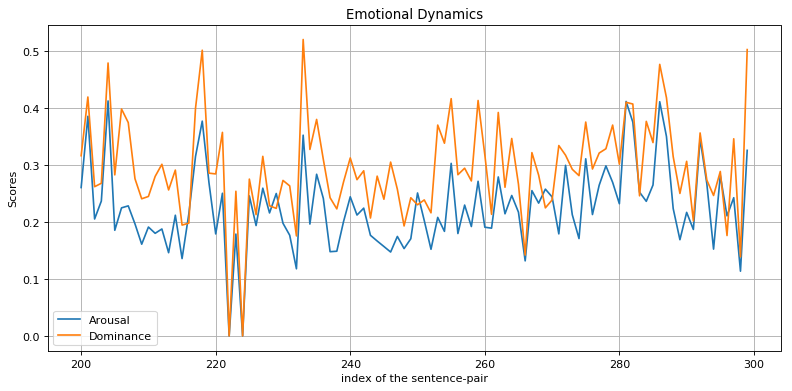

In [90]:
# Plot the Dominance scores for the 100 sentences 
plotScores("Dominance",200)

#### Find the suitable parameter for extracting the semantic feature later. 

In [21]:
#Propotion of the parallel sentence-pairs in the whole dataset
print("Proportion of 'T' - Whole dataset: ", round(tags.count("T")/len(tags), 4))

Proportion of 'T' - Whole dataset:  0.2232


In [22]:
# Calculate the proportion of parallel sentence-pairs under certain conditions.
#     Condition 2: When the intensity (Arousal or Doninance) of both sentences in a sentence pair 
#                  are greater than a certain threshold.
# Select the threshold that can get the highest proportion under Condition 2 and enough samples.

def getProportion_High(threshold, emoDimension):
    Ts = 0
    Fs = 0
    for index in range(len(tags)-1):
        if emoDimension[index] > threshold and emoDimension[index+1] > threshold:
            if tags[index] == "T" :
                Ts+=1
            else:
                Fs +=1
    #print(Ts, "Ts")
    #print(Fs, "Fs")
    if Fs+Ts == 0:
        return 0
    else:
        proportion = round(Ts/(Fs+Ts), 4)
        return proportion


In [23]:
getProportion_High(0.38, intensity_D)

0.8

In [24]:
getProportion_High(0.29, intensity_A)

0.7778

In [25]:
def plot_Proportion_High(emoDimension):
    axis_x = [0.01* x for x in range(0,60)]
    axis_y = []
    for x in axis_x:
        axis_y.append(getProportion_High(x, emoDimension) * 100)
    plt.figure(figsize=(10,4), dpi=60)
    plt.plot(axis_x, axis_y)
    plt.xlabel("Threshold")
    plt.ylabel("Proportion of Parallelism (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



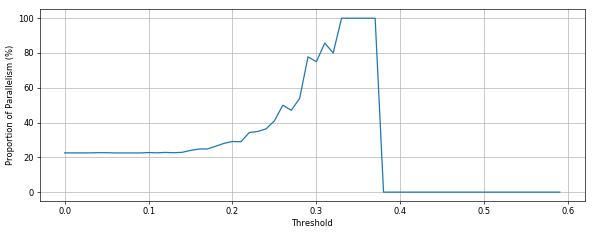

In [26]:
plot_Proportion_High(intensity_A)

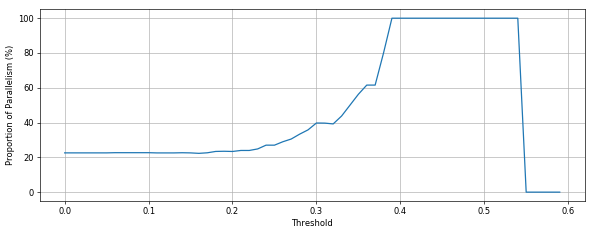

In [27]:
plot_Proportion_High(intensity_D)

In [28]:
# Calculate the proportion of parallel sentence-pairs under certain conditions.
#     Condition 1: When the difference (absolute value) of intensity (Arousal or Doninance)
#                  is lower than a certain threshold.
# Select the threshold that can get the highest proportion under Condition 1 and enough samples.

def getProportion_Diff(threshold, emoDimension): 
    Ts = 0
    Fs = 0
    for index in range(len(tags)-1):
        if abs(emoDimension[index] - emoDimension[index+1]) < threshold: 
            if tags[index] == "T" :
                #print(index)
                Ts+=1
            else:
                Fs +=1
    #print(Ts, "Ts")
    #print(Fs, "Fs")
    if Fs+Ts == 0:
        return 0
    else:
        proportion = round(Ts/(Fs+Ts), 4)
        return proportion  


In [74]:
print(getProportion_Diff(0.06,intensity_D))
print(getProportion_Diff(0.01,intensity_V))


0.257
0.3611


In [30]:
def plot_Proportion_Diff(emoDimension):
    axis_x = [0.01* x for x in range(30)]
    axis_y = []
    for x in axis_x:
        axis_y.append(getProportion_Diff(x, emoDimension)*100)
    plt.figure(figsize=(7,4), dpi=60)
    plt.plot(axis_x, axis_y)
    plt.xlabel("Absolute Difference (Threshold)")
    plt.ylabel("Proportion of Parallelism (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


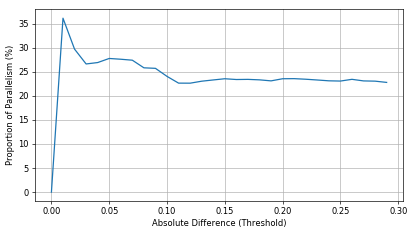

In [31]:
plot_Proportion_Diff(intensity_V)

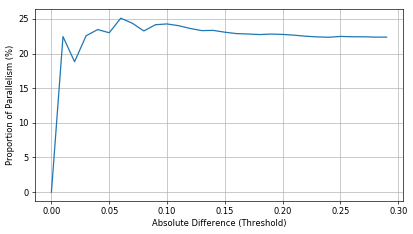

In [32]:
plot_Proportion_Diff(intensity_A)

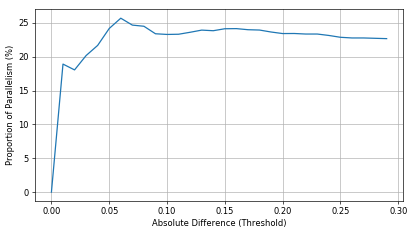

In [33]:
plot_Proportion_Diff(intensity_D)

### Syntactic Features

In [34]:
# used for comparing 2 phrases as string
from difflib import SequenceMatcher

def compare(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio() 
# returns the similarity score (float in [0,1]) between input strings, the higher the score is, more similar 2 Strings are. 


In [35]:
# Normalized PoS-tag sequence
def get_pos_seq (word_tag_sequence):
    pos_sequence = ''.join([w[w.index("_"):w.index("_")+3] for w in word_tag_sequence])
    return pos_sequence

In [36]:
def similarPoS(sent1, sent2):
    if ",_," not in sent1 and ",_," not in sent2:
        simiScore = compare(get_pos_seq(sent1.split()),get_pos_seq(sent2.split()))
        return simiScore > 0.74
    else:
        # If two sentences contains sub-sentences, 
        # the last subsentence of sent1 and the first subsentence of sent2 are compared (adjacent phrases)
        toCompareS1 = sent1.split(",_,")[-1].split() 
        toCompareS2 = sent2.split(",_,")[0].split()
        simiScore = compare(get_pos_seq(toCompareS1), get_pos_seq(toCompareS2))
        return simiScore > 0.79

In [37]:
s8 = "The_DT Capital_NN was_VBD abandoned_VBN ._."
s9 = "The_DT enemy_NN was_VBD advancing_VBG ._."

In [38]:
similarPoS(s8, s9)

True

### Baseline 

In [39]:
precision = 101/448
recall = 101/101
f_score = 2 * precision * recall / (precision + recall)
print(f_score)

0.3679417122040073


### Classifier Training

In [40]:
def get_features1(sent1, sent2):
    features = {}
    # Lexical features: Repeated bigrams in specific positions (Anaphora / Epistrophe / Anadiplosis)
    features["simiLexical"] = specialParaLexical(sent1, sent2) > 0
    # Syntactic features (pos-tag sequence): 
    features["simiSyntactic"] = similarPoS(sent1, sent2)

    domiS1 = getAvgDominance(sent1)
    domiS2 = getAvgDominance(sent2)
    arouS1 = getAvgArousal(sent1)
    arouS2 = getAvgArousal(sent2)
    
    features["highArous"] = arouS1 > 0.28 and arouS2 > 0.28
    features["highDomi"] = domiS1 > 0.37 and domiS2 > 0.37

    return features


In [41]:
import random

In [42]:
# define this function for evaluation
def compute_PRF(gold, predicted, class_label):
    TP = sum(int(g == class_label and p == class_label) for (g, p) in zip (gold, predicted))
    FP = sum(int(p == class_label and g != class_label) for (g, p) in zip (gold, predicted)) 
    FN = sum(int(p != class_label and g == class_label) for (g, p) in zip (gold, predicted))
    if TP + FP > 0:
        precision = TP/(TP + FP)
    else:
        precision = 0
    if TP + FN > 0:
        recall = TP/(TP + FN)
    else:
        recall = 0
    if precision > 0 and recall > 0:
        f_measure = 2 * precision * recall / (precision + recall)
    else:
        f_measure = 0
    #print('Precision=%.2f Recall=%.2f F_Measure=%.2f'  %  (precision, recall, f_measure))
    return (precision, recall, f_measure)

In [45]:
# cross validation
k = 5
sum_precision = 0
sum_recall = 0
sum_f_measure = 0
random.Random(5).shuffle(dataset) 
featuresets = [(get_features1(sent1, sent2), tag) for (sent1,sent2, tag) in dataset ]
size = len(featuresets)
for fold in range(k):
    train_set = featuresets[: int(size/k*fold)] + featuresets[int(size/k*(fold+1)):]
    devtest_set = featuresets[int(size/k*fold) : int(size/k*(fold+1))]
    nb = nltk.NaiveBayesClassifier.train(train_set)
    gold = [tag for (sent_feature, tag) in devtest_set]
    pred1 = [nb.classify(sent_feature) for (sent_feature, tag) in devtest_set]
    sum_precision += compute_PRF(gold, pred1, "T")[0]
    sum_recall += compute_PRF(gold, pred1, "T")[1]
    sum_f_measure += compute_PRF(gold, pred1, "T")[2]

print("\ncross validated precision for 'T' is: ", sum_precision/5)
print("\ncross validated recall for 'T' is: ", sum_recall/5)
print("\ncross validated f-measure for 'T' is: ", sum_f_measure/5)


cross validated precision for 'T' is:  0.8875829648881204

cross validated recall for 'T' is:  0.8930487137383689

cross validated f-measure for 'T' is:  0.8861694539113895


In [47]:
nb.show_most_informative_features(5)

Most Informative Features
             simiLexical = True                T : F      =     26.6 : 1.0
                highDomi = True                T : F      =      6.5 : 1.0
               highArous = True                T : F      =      6.5 : 1.0
             simiLexical = False               F : T      =      5.0 : 1.0
           simiSyntactic = False               F : T      =      1.2 : 1.0


In [48]:
# False Positives
for (sent1,sent2, tag) in dataset:
    if nb.classify(get_features1(sent1, sent2)) == 'T' and tag == 'F':
        print(sent1, sent2)
        print()

Thomas_NNP Jefferson_NNP believed_VBD that_IN to_TO preserve_VB the_DT very_RB foundations_NNS of_IN our_PRP$ Nation_NNP ,_, we_PRP would_MD need_VB dramatic_JJ change_NN from_IN time_NN to_TO time_NN ._.
 Well_UH ,_, my_PRP$ fellow_JJ Americans_NNPS ,_, this_DT is_VBZ our_PRP$ time_NN ._.


America_NNP will_MD start_VB winning_VBG again_RB ,_, winning_VBG like_IN never_RB before_RB ._.
 We_PRP will_MD bring_VB back_RP our_PRP$ jobs_NNS ._.


We_PRP will_MD seek_VB friendship_NN and_CC good_NN will_MD with_IN the_DT nations_NNS of_IN the_DT world_NN ,_, but_CC we_PRP do_VBP so_RB with_IN the_DT understanding_NN that_IN it_PRP is_VBZ the_DT right_NN of_IN all_DT nations_NNS to_TO put_VB their_PRP$ own_JJ interests_NNS first_RB ._.
 We_PRP do_VBP not_RB seek_VB to_TO impose_VB our_PRP$ way_NN of_IN life_NN on_IN anyone_NN ,_, but_CC rather_RB to_TO let_VB it_PRP shine_VB as_IN an_DT example—we_NN will_MD shine—for_VB everyone_NN to_TO follow_VB ._.


Those_DT ideals_NNS still_RB light_VB

In [100]:
get_features1(
    "Homes_NNPS have_VBP been_VBN lost_VBN ,_, jobs_NNS shed_VBD ,_, businesses_NNS shuttered_VBD ._.",
 "Our_PRP$ health_NN care_NN is_VBZ too_RB costly_JJ ._."
)

{'simiLexical': False,
 'simiSyntactic': False,
 'highArous': True,
 'highDomi': True}

In [51]:
# False Negatives
for (sent1,sent2, tag) in dataset:
    if nb.classify(get_features1(sent1,sent2)) == 'F' and tag == 'T':
        print(sent1,sent2)
        print()

But_CC when_WRB most_JJS people_NNS are_VBP working_VBG harder_RBR for_IN less_JJR ;_:
  when_WRB others_NNS can_MD not_RB work_VB at_IN all_DT ;_:


Our_PRP$ workers_NNS are_VBP no_RB less_RBR productive_JJ than_IN when_WRB this_DT crisis_NN began_VBD ._.
 Our_PRP$ minds_NNS are_VBP no_RB less_RBR inventive_JJ ._.


From_IN this_DT this_DT day_NN forward_RB ,_, it_PRP 's_VBZ going_VBG to_TO be_VB only_RB America_NNP first_RB ._.
 America_NNP first_RB ._.


And_CC you_PRP have_VBP changed_VBN the_DT face_NN of_IN Congress_NNP ,_, the_DT Presidency_NNP ,_, and_CC the_DT political_JJ process_NN itself_PRP ._.
 Yes_UH ,_, you_PRP ,_, my_PRP$ fellow_JJ Americans_NNPS ,_, have_VBP forced_VBN the_DT spring_NN ._.


 that_IN whether_IN we_PRP are_VBP Black_JJ or_CC Brown_JJ or_CC White_NNP ,_, we_PRP all_DT bleed_VBP the_DT same_JJ red_JJ blood_NN of_IN patriots_NNS ,_, we_PRP all_DT enjoy_VBP the_DT same_JJ glorious_JJ freedoms_NNS ,_, and_CC we_PRP all_DT salute_VBP the_DT same_JJ great_JJ 

In [75]:
def get_features2(sent1, sent2):
    features = {}
    # Lexical features: Repeated bigrams in specific positions (Anaphora / Epistrophe / Anadiplosis)
    features["simiLexical"] = specialParaLexical(sent1, sent2) > 0
    # Syntactic features (pos-tag sequence): 
    features["simiSyntactic"] = similarPoS(sent1, sent2)

    domiS1 = getAvgDominance(sent1)
    domiS2 = getAvgDominance(sent2)
    arouS1 = getAvgArousal(sent1)
    arouS2 = getAvgArousal(sent2)
    valenceS1 = getAvgV(sent1)
    valenceS2 = getAvgV(sent2)
    
    features["simiArous"] = abs(arouS1 - arouS2) < 0.06
    features["simiDomi"] = abs(domiS1 - domiS2) < 0.06
    features["simiV"] = abs(valenceS1 - valenceS2) < 0.01
    
    features["highArous"] = arouS1 > 0.28 and arouS2 > 0.28
    features["highDomi"] = domiS1 > 0.37 and domiS2 > 0.37
    
    #print(1)
    return features


In [76]:
# Extract features from the sentence pairs and store them in proper format.
transformed_data = []
for [sent1, sent2, tag] in dataset:
    features_tag = []
    simiLexical = get_features2(sent1,sent2)["simiLexical"]
    simiSyntactic = get_features2(sent1,sent2)["simiSyntactic"]
    highDomi = get_features2(sent1,sent2)["highDomi"]
    highArous = get_features2(sent1,sent2)["highArous"]
    simiDomi = get_features2(sent1,sent2)["simiDomi"]
    simiArous = get_features2(sent1,sent2)["simiArous"]
    simiV = get_features2(sent1,sent2)["simiV"]
    
    features_tag.extend([sent1,sent2, simiLexical,simiSyntactic,highDomi,highArous,simiDomi,simiArous,simiV,tag])
    transformed_data.append(features_tag)  # use append to maintain list form
len(transformed_data)

448

In [77]:
df_data = pd.DataFrame(transformed_data, columns = ['sent1','sent2','simiLexical','simiSyntactic','highDomi','highArous','simiDomi','simiArous','simiV','tag'])
df_data.head(5)



,sent1,sent2,simiLexical,simiSyntactic,highDomi,highArous,simiDomi,simiArous,simiV,tag
0,We_PRP 've_VBP defended_VBN other_JJ nations_N...,We_PRP 've_VBP made_VBN other_JJ countries_NNS...,True,False,False,False,False,True,False,T
1,And_CC to_TO those_DT nations_NNS like_IN ours...,As_IN we_PRP consider_VBP the_DT road_NN that_...,False,False,False,False,True,True,False,F
2,You_PRP came_VBD by_IN the_DT tens_NNS of_IN m...,At_IN the_DT center_NN of_IN this_DT movement_...,False,False,False,False,False,True,True,F
3,These_DT things_NNS are_VBP true_JJ ._.\n,They_PRP have_VBP been_VBN the_DT quiet_JJ for...,False,False,True,False,True,True,False,F
4,Though_IN our_PRP$ challenges_NNS are_VBP fear...,Americans_NNPS have_VBP ever_RB been_VBN a_DT ...,False,False,False,True,True,True,False,F


In [78]:
feature_cols = ['simiLexical','simiSyntactic','highDomi','highArous','simiDomi','simiArous','simiV']

X = df_data[feature_cols]
y = df_data.tag 

In [79]:
# Feature selection
from sklearn.feature_selection import SelectKBest, chi2


In [91]:
sel_chi2 = SelectKBest(chi2, k=4)    # select 4 features
X_withEmo = sel_chi2.fit_transform(X, y)
print(sel_chi2.get_support())

[ True  True  True  True False False False]


In [99]:
sel_chi2 = SelectKBest(chi2, k=3)    # select 3 features
X_3Best = sel_chi2.fit_transform(X, y)
print(sel_chi2.get_support())

[ True  True  True False False False False]


In [81]:
sel_chi2 = SelectKBest(chi2, k=2)    # select 2 features
X_noEmo = sel_chi2.fit_transform(X, y)
print(sel_chi2.get_support())

[ True  True False False False False False]


In [82]:
# use cross validation to evaluate the results:
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics

In [83]:
# Try different algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC 

# initialize classifiers
knn = KNeighborsClassifier()
lr = LogisticRegression()
svc = LinearSVC()

In [84]:
from sklearn.cross_validation import KFold
kf_5 = KFold(n = 448, n_folds = 5)

In [85]:
def tryClassifier(Text, labels, clf, evaluation_tag):
    precisions = 0
    recalls = 0
    f_measures = 0
    # For each iteration: 1 fold out of 5 folds are used as test set and the other 4 folds as training set.
    # At the end every fold is used as test set once.
    # The average scores are considered as cross-validated (CV) scores.
    
    for (train_index, test_index) in kf_5:  
        X_train, X_test = np.asarray(Text)[train_index], np.asarray(Text)[test_index]  # convert dataFrame(X,y) into array!
        y_train, y_test = np.asarray(labels)[train_index], np.asarray(labels)[test_index]  # Because index works with array!
        
        clf.fit(X_train, y_train)
        tag_pred = clf.predict(X_test)
        
        #print(metrics.classification_report(y_test, tag_pred)) 
        # The line above can be used if detailed evaluation-info for each train/test set is wanted.

        precisions += metrics.precision_score(y_test, tag_pred,  pos_label = evaluation_tag)
        recalls += metrics.recall_score(y_test, tag_pred, pos_label = evaluation_tag)
        f_measures += metrics.f1_score(y_test, tag_pred, pos_label = evaluation_tag)
  
    
    print(evaluation_tag, ": CV_Precion: ", round(precisions/5,4), "CV_Recall:", round(recalls/5,4),"CV_F_measure: ", round(f_measures/5, 4))




In [86]:
# used features: 'simiLexical','simiSyntactic'
tryClassifier(X_noEmo, y, knn,"T")
tryClassifier(X_noEmo, y, lr,"T")
tryClassifier(X_noEmo, y, svc,"T")

T : CV_Precion:  0.8978 CV_Recall: 0.8877 CV_F_measure:  0.8902
T : CV_Precion:  0.8967 CV_Recall: 0.8655 CV_F_measure:  0.877
T : CV_Precion:  0.8978 CV_Recall: 0.8877 CV_F_measure:  0.8902


In [92]:
# used features: 'simiLexical','simiSyntactic','highDomi','highArous'
tryClassifier(X_withEmo, y, knn,"T")
tryClassifier(X_withEmo, y, lr,"T")
tryClassifier(X_withEmo, y, svc,"T")

T : CV_Precion:  0.8971 CV_Recall: 0.8618 CV_F_measure:  0.8747
T : CV_Precion:  0.8971 CV_Recall: 0.8618 CV_F_measure:  0.8747
T : CV_Precion:  0.8978 CV_Recall: 0.8877 CV_F_measure:  0.8902


In [97]:
 0.8747 - 0.877

-0.0022999999999999687